# Used Car Sale Auction Prices
By Sky Reznik, John Lackey and Kevin Abatto
2025-04-22

Import packages

In [17]:
import pandas as pd; # type: ignore
import numpy as np; # type: ignore
import seaborn as sns; # type: ignore
import matplotlib.pyplot as plt; # type: ignore
from holoviews.operation import histogram;
from sklearn.preprocessing import OneHotEncoder; # type: ignore
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LinearRegression;
from sklearn.metrics import mean_squared_error, r2_score;
import os;

|Import data

In [18]:
# Load CSV into a pandas dataframe
shared_file_path = './kaggle_datasets/car_prices.csv'
# line 408,163 - "Model" field contains a comma (SE PZEV w/Connectivity, Navigation) - specify quotechar='"'
# This tells Pandas to treat anything inside double quotes as a single field, even if it contains commas.
#      solution provided by ChatGPT
df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')

/var/folders/kt/8ctq9zmj7wvf5t0bwkg6sbjr0000gn/T/ipykernel_9284/532372311.py:6: DtypeWarning:

Columns (8,13,16) have mixed types. Specify dtype option on import or set low_memory=False.



Now we need at append the MSRP of these cars. By using a data set that had make, model, year, transmission, etc. we can match the values and add in the MSRP.

We have excluded trim and chosen the lowest price match to avoid over saturating the data with multiple trim levels at different prices of the same vehicle.

In [19]:
# Load datasets
msrp = pd.read_csv('MSRP.csv')

# Standardize column names and values
msrp.rename(columns={
    'Make': 'make',
    "Model": "model",
    "Year": "year",
    "Transmission Type": "transmission"
}, inplace=True)

msrp['transmission'] = msrp['transmission'].str.lower()

# Create matching keys
df['match_key'] = (
    df['year'].astype(str).str.lower() + '_' + 
    df['make'].str.lower() + '_' + 
    df['model'].str.lower() + '_' + 
    df['transmission'].str.lower()
)

msrp['match_key'] = (
    msrp['year'].astype(str).str.lower() + '_' + 
    msrp['make'].str.lower() + '_' + 
    msrp['model'].str.lower() + '_' + 
    msrp['transmission'].str.lower()
)

# Sort by MSRP (ascending) and keep first (min) for each match_key
msrp_min_row = msrp.sort_values('MSRP').drop_duplicates('match_key', keep='first')

# Merge with original car data (keeping all car rows but adding MSRP where matched)
car_with_msrp = df.merge(
    msrp_min_row[['match_key', 'MSRP']],  # Only keep needed columns
    on='match_key',
    how='left'
)

# Drop the temporary key column
car_with_msrp = car_with_msrp.drop(columns=['match_key'])

# Save the merged DataFrame to a new CSV file
car_with_msrp.to_csv('car_prices_with_msrp.csv', index=False)

# Data Cleaning

1) Remove any row with missing data with df.dropna()
2) One-Hot encode ['transmission'] to ['automatic_trans'] 0 /1 (double check unique vals)
3) Simplify ['body'] (collapse all 85 body types to 9 types)
4) Convert ['saledate']
5) Age of car (from ['saledate'])
6) Drop negative age cars
7) Drop unessecary or redundant columns
8) Make 'condition' numeric
9) Avoid outlier by using the 95th percentile

In [20]:
# now we can use the car_prices_with_msrp DataFrame
df = pd.read_csv('car_prices_with_msrp.csv', low_memory=False)
# Remove 'Unamed: 16' column
df.drop('Unnamed: 16', axis=1, inplace=True)
df['odometer'] = np.where(df['odometer'] == 999999.0, np.nan, df['odometer'])

1 - Remove rows that have missing values


In [21]:
df.dropna(inplace=True)

2 - One-hot encode the 'transmission' column


In [22]:
print(df['transmission'].unique())
df['auto_transmission'] = np.where(df['transmission'].str.contains('automatic', case=False), 1, 0)

['automatic' 'manual']


3 - 'One-hot encode' the 'body' column (count 85 unique values --> reduce to 8)


In [23]:
# ['suv' 'sedan' 'convertible' 'coupe' 'wagon' 'hatchback' 'truck' 'minivan' 'van']
df['body_type'] = np.nan
df['body_type'] = np.where(df['body'].str.contains('minivan', case=False), 'minivan', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('sedan', case=False), 'sedan', df['body'])
df['body_type'] = np.where(df['body'].str.contains('wagon', case=False), 'wagon', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('coupe', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('koup', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('convertible', case=False), 'convertible', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('hatchback', case=False), 'hatchback', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains(r'\bvan\b', case=False), 'van', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('truck', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('cab', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('crew', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('suv', case=False), 'suv', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('Minivan', case=False), 'minivan', df['body_type'])

# Numerical mapping for body types
size_mapping = {
    'convertible': 0,
    'coupe': 1,
    'hatchback': 2,
    'sedan': 3,
    'wagon': 4,
    'suv': 5,
    'minivan': 6,
    'truck': 7,
    'van': 8
}

df['body_size'] = df['body_type'].map(size_mapping)

4 - Converting 'saledate' to datetime (solution provided by ChatGPT)

In [24]:
# Handle invalid or unexpected values in the 'saledate' column
# Extract just the date part (e.g., "Dec 16 2014") before conversion
df['saledate'] = pd.to_datetime(
    df['saledate'].str.extract(r'(\w{3} \d{2} \d{4})')[0], 
    format='%b %d %Y', 
    errors='coerce'
)

5 - Create a new column 'car_age'

In [25]:
df['car_age'] = np.where(df['saledate'].notna(), df['saledate'].dt.year - df['year'], np.nan)

6 - Some car ages are negative (which is not possible) because a 2015 model year can exist in 2014 and subsequently be sold

In [26]:
# For rows with values less than 0, drop rows
print("Number of negative car ages dropped: ", df[df['car_age'] < 0].shape[0])
df.drop(df[df['car_age'] < 0].index, inplace=True)
# Drop old columns 'transmission' & 'body'
df.drop(['transmission', 'body'], axis=1, inplace=True)

Number of negative car ages dropped:  135


7 - Drop unessecary or redundant columns

In [27]:
df.drop(['year', 'trim', 'vin', 'color', 'interior', 'saledate', 'body_type'], axis=1, inplace=True)

8 - Make 'condition' numeric

In [28]:
df['condition'] = pd.to_numeric(df['condition'], errors='coerce')

9 - Use only th 95th percentile of the data to avoid outliers

<Axes: xlabel='sellingprice', ylabel='Count'>

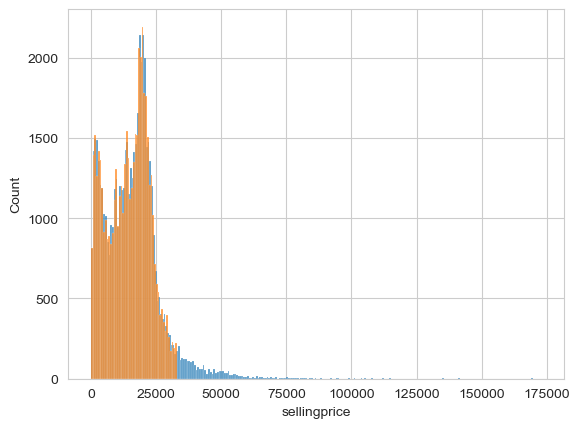

In [29]:
sns.histplot(data=df, x='sellingprice')
threshold = df['sellingprice'].quantile(0.95)
df = df[df['sellingprice'] <= threshold]
sns.histplot(data=df, x='sellingprice')

10 - Creating 'sold_above_mmr'

MMR is provided in the dataset... it is the "Mannheim Market Report", an estimation of a car's selling value, which is updated nightly, and trained on millions of auction transactions. For our auction data, we can assume it is a sellers goal to surpass the MMR in the auction.

Therefore, a relevant one-hot-encoding would be if the `sellingprice` > `mmr`. While it is good practice to not have redundant columns; ones which can be inferred from the data, a binary column `sold_above_mmr` would be highly useful for #TODO geographical visualizations and determining which sellers or states outpreform their estimated MMR.

We will create this variable below:

In [30]:
# ensure mmr and sellingprice are numeric
df['mmr'] = pd.to_numeric(df['mmr'], errors='coerce')
df['sellingprice'] = pd.to_numeric(df['sellingprice'], errors='coerce')
df['sold_above_mmr'] = np.where(df['sellingprice'] > df['mmr'], 1, 0 )
df[['sellingprice', 'mmr', 'sold_above_mmr']].sample(4)

,sellingprice,mmr,sold_above_mmr
314854,23000,25000,0
87475,18000,17900,1
28658,1100,700,1
397599,4600,3975,1


In [31]:
# Save clean data to CSV
df.to_csv('cleaned_car_prices.csv', index=False)

In [32]:
# Re-load the cleaned data
df = pd.read_csv('cleaned_car_prices.csv', low_memory=False)

# Exploratory Data Analysis

First, let's learn more about our data now that is has been cleaned!

In [33]:
print(df.columns.unique())

Index(['make', 'model', 'state', 'condition', 'odometer', 'seller', 'mmr',
       'sellingprice', 'MSRP', 'auto_transmission', 'body_size', 'car_age',
       'sold_above_mmr'],
      dtype='object')


#### DataFrame Features Overview

##### 1. make
- **Description**: The manufacturer/brand of the vehicle
- **Type**: Categorical (e.g., Toyota, Ford, Honda)
- **Potential Use**: Grouping vehicles by brand for analysis

##### 2. model
- **Description**: The specific model name of the vehicle
- **Type**: Categorical (e.g., Camry, F-150, Escape)
- **Potential Use**: Detailed vehicle identification when combined with make

##### 3. state
- **Description**: The geographical state where the vehicle is located/registered
- **Type**: Categorical (e.g., CA, TX, NY)
- **Potential Use**: Regional price analysis or demand patterns

##### 4. condition
- **Description**: The physical/mechanical condition of the vehicle
- **Type**: Numerical (0-5)
- **Potential Use**: Key factor in pricing models

##### 5. odometer
- **Description**: The mileage reading showing how many miles the vehicle has traveled
- **Type**: Numerical (continuous)
- **Potential Use**: Strong predictor of vehicle value and wear

##### 6. seller
- **Description**: The party selling the vehicle 
- **Type**: Categorical
- **Potential Use**: Analyzing price differences between seller types

##### 7. mmr (Manheim Market Report)
- **Description**: Wholesale market valuation of the vehicle caluculated and updated every 24 hours
- **Type**: Numerical (currency USD)
- **Potential Use**: Benchmark for comparing selling prices

##### 8. sellingprice
- **Description**: The actual auction sale price of the vehicle
- **Type**: Numerical (currency USD)
- **Potential Use**: Target variable for price prediction models

##### 9. MSRP (Manufacturer's Suggested Retail Price)
- **Description**: The original new vehicle price recommended by manufacturer
- **Type**: Numerical (currency USD)
- **Potential Use**: Baseline for depreciation calculations

##### 10. auto_transmission
- **Description**: Whether the vehicle has automatic transmission
- **Type**: Boolean (0/1)
- **Potential Use**: Analyzing price differences between transmission types

##### 11. body_size
- **Description**: The size classification of the vehicle
- **Type**: Ordinal numerical (1=smallest to 8=largest)
- **Potential Use**: Market segment analysis

##### 12. car_age
- **Description**: The age of the vehicle in years
- **Type**: Numerical (discrete)
- **Potential Use**: Key factor in depreciation models

##### 13. sold_above_mmr
- **Description**: The age of the vehicle in years
- **Type**: Boolean (1/0)
- **Potential Use**: Determining shortcomings of MMR model

Here is a look at the format of the dataframe and what a line look like:

In [34]:
print(df.sample(1))

         make   model state  condition  odometer                     seller  \
43126  Toyota  Tacoma    va        5.0    6296.0  sullivan auto trading inc   

         mmr  sellingprice     MSRP  auto_transmission  body_size  car_age  \
43126  26300         25500  21865.0                  1          7      0.0   

       sold_above_mmr  
43126               0  


#### Boxplots
First, lets look at some bloxplots of our numerical features to understand the spread of our data.

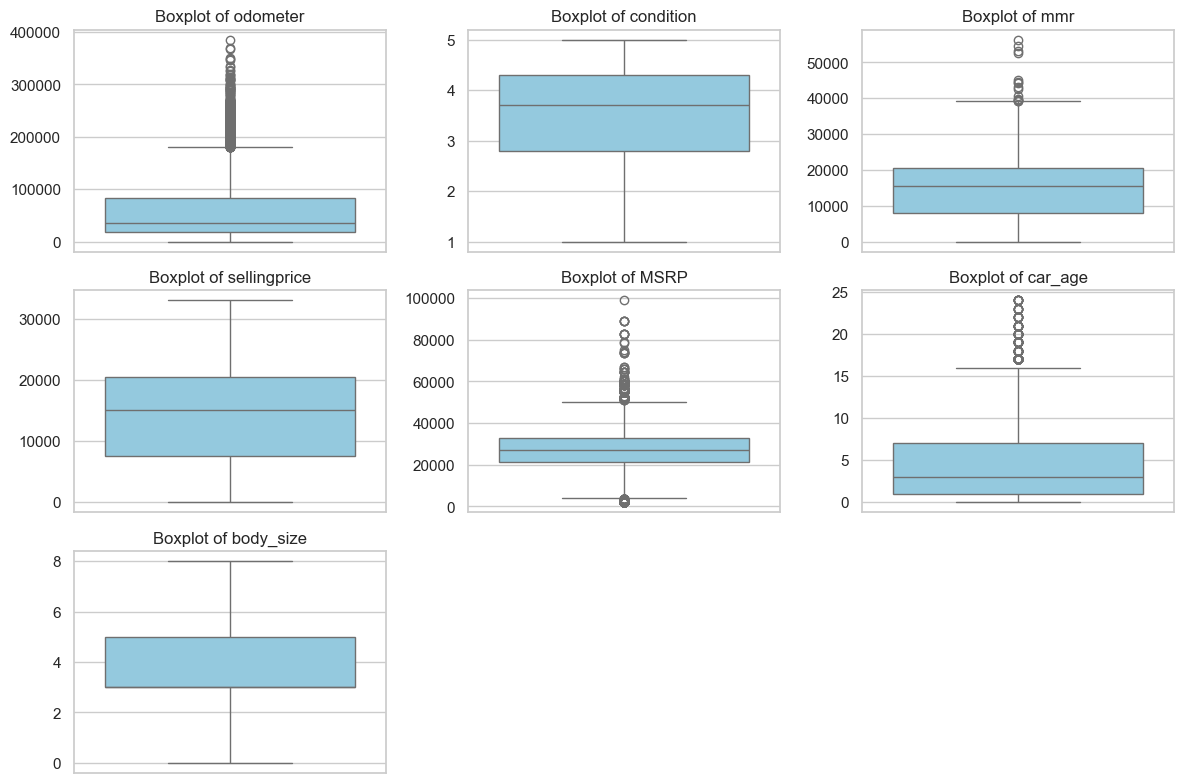

In [35]:
sns.set(style="whitegrid")

# Select numerical columns
numerical_cols = ['odometer', 'condition', 'mmr', 'sellingprice', 'MSRP', 'car_age', 'body_size']

# Create subplots
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel('')

plt.tight_layout()  # Prevent overlapping
plt.show()

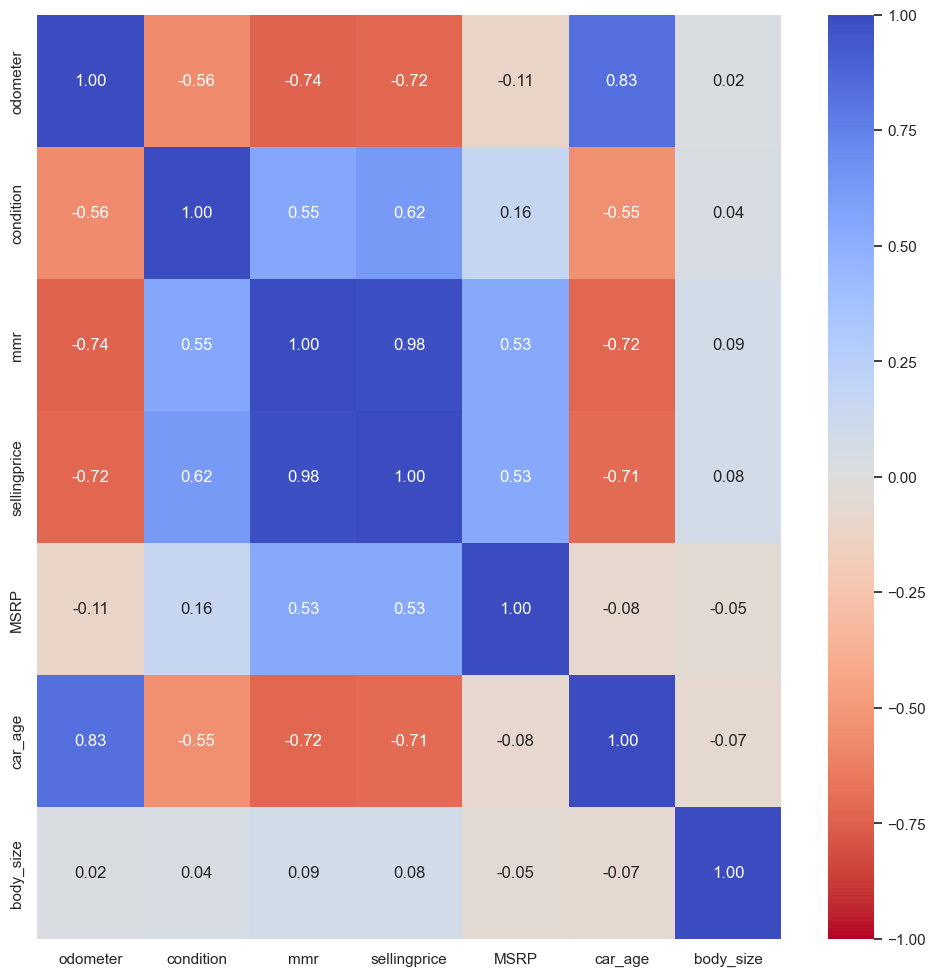

In [36]:

plt.figure(figsize = (12, 12))
sns.heatmap(
    df[numerical_cols].corr(),
    annot = True,
    fmt = '.2f',
    cmap = 'coolwarm_r',
    vmin = -1, 
    vmax = 1
);

For fun, let's do some visualizations

GeoPandas version: 1.0.1


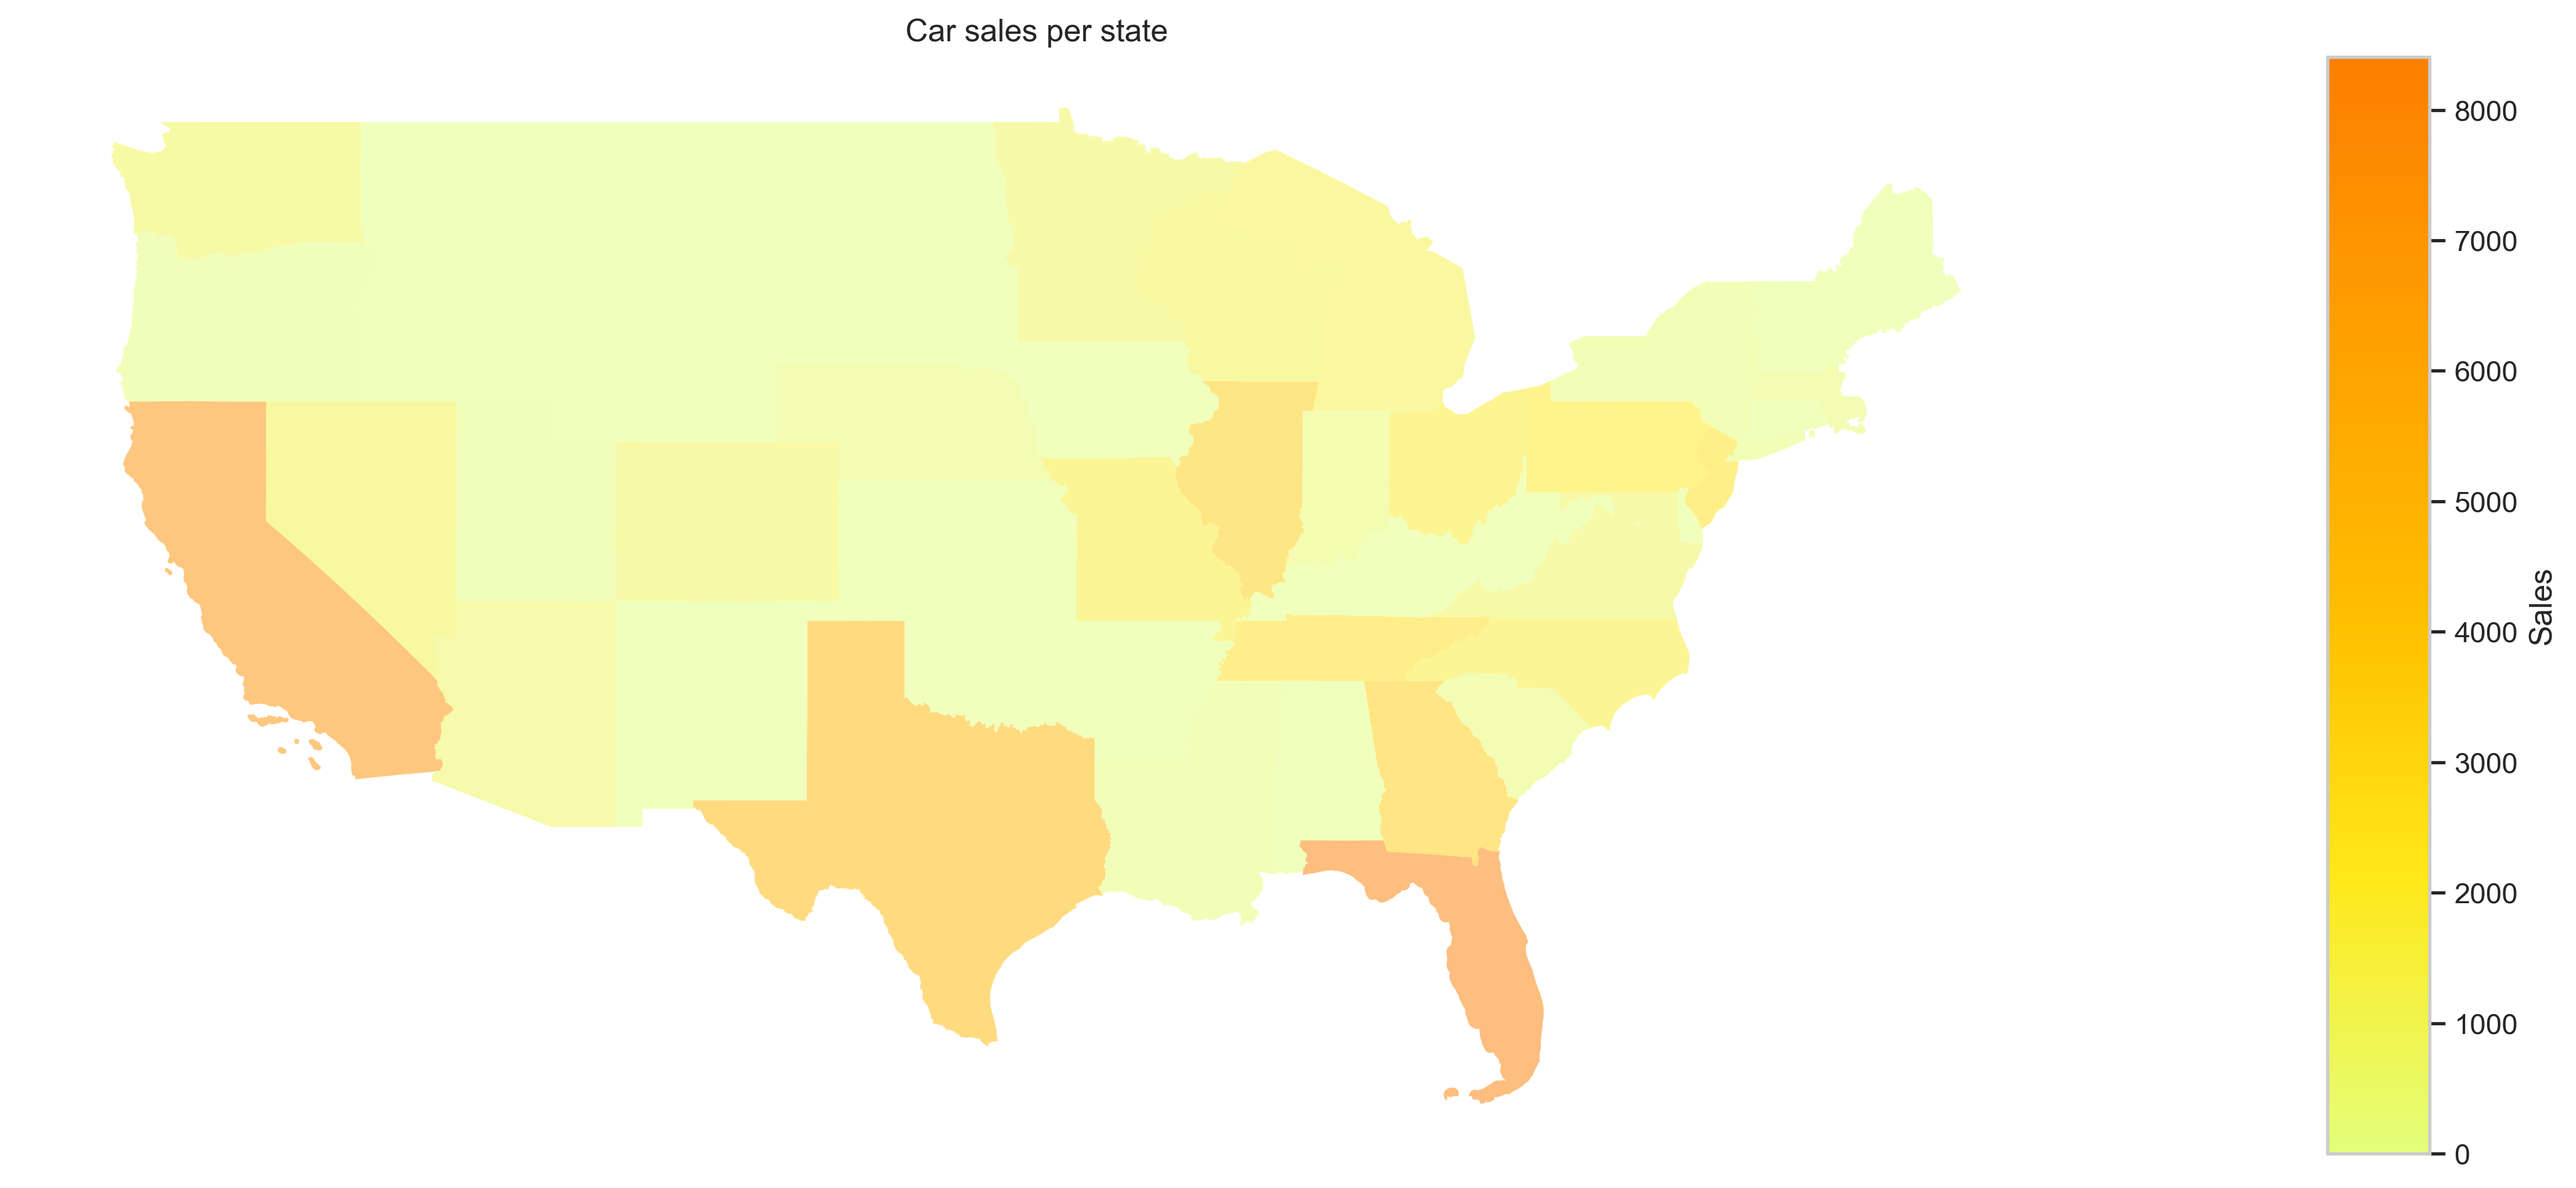

In [37]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
#https://geopandas.org/en/stable/docs/user_guide/mapping.html

# Verify the installation by printing the version
print(f"GeoPandas version: {gpd.__version__}")

gdf = gpd.read_file('tl_2024_us_state/tl_2024_us_state.shp') #read file from US census
gdf = gdf.to_crs("EPSG:4326")

df2 = pd.read_csv('cleaned_car_prices.csv')

sales_counts = df2['state'].value_counts().reset_index()
sales_counts.rename(columns={'state':'STUSPS'}, inplace=True) # rename for merge
sales_counts['STUSPS'] = sales_counts['STUSPS'].str.upper() # uppercase for merge

merged_df = gdf.merge(sales_counts, how='left', on='STUSPS')

non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = merged_df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

# format and convert NaN's to zeroes
us49.rename(columns={'count':'NUM_SALES'}, inplace=True)
us49.fillna(0, inplace=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import colormaps

# Source for function https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77
def StatesPlot(df,data, cmap):
    f,ax = plt.subplots(1,1, figsize=(15,10),
    sharex=True, sharey=True, dpi=300)
    f.tight_layout()
    plt.title('Car sales per state')
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%",
    pad=0.1,alpha=0.01)
    df.plot(data, ax=ax, alpha=0.5, cmap=cmap,
    edgecolor='none', legend=True, cax=cax, linewidth=0.3)
    plt.ylabel('Sales', fontsize=12)
    plt.show()

StatesPlot(us49, 'NUM_SALES', cmap='Wistia')

In [38]:
import plotly.express as px
# Sample data
treemap_df = df2['make'].value_counts().reset_index()
treemap_df.columns = ['make', 'count']

make_to_country = {
    "Infiniti": "Japan",
    "Dodge": "USA",
    "Chevrolet": "USA",
    "Chrysler": "USA",
    "Kia": "South Korea",
    "Ford": "USA",
    "Lexus": "Japan",
    "Pontiac": "USA",
    "Nissan": "Japan",
    "Hyundai": "South Korea",
    "Acura": "Japan",
    "GMC": "USA",
    "Mazda": "Japan",
    "Buick": "USA",
    "Toyota": "Japan",
    "Lincoln": "USA",
    "Volkswagen": "Germany",
    "Cadillac": "USA",
    "Honda": "Japan",
    "Suzuki": "Japan",
    "Subaru": "Japan",
    "Volvo": "Sweden",
    "Mitsubishi": "Japan",
    "Mercedes-Benz": "Germany",
    "Scion": "Japan",
    "Oldsmobile": "USA",
    "BMW": "Germany",
    "HUMMER": "USA",
    "Land Rover": "UK",
    "Saab": "Sweden",
    "Audi": "Germany",
    "Porsche": "Germany",
    "Plymouth": "USA",
    "FIAT": "Italy",
    "Maserati": "Italy"
}

treemap_df['country'] = treemap_df['make'].map(make_to_country)

fig = px.treemap(
    treemap_df,
    path=['country','make'],
    values='count',
    color='country',
color_discrete_sequence=px.colors.qualitative.Safe)

fig.update_layout(margin=dict(t=30, l=10, r=10, b=10))
fig.show()


# Data Predictions
#### 'mmr' v. 'sellingprice'


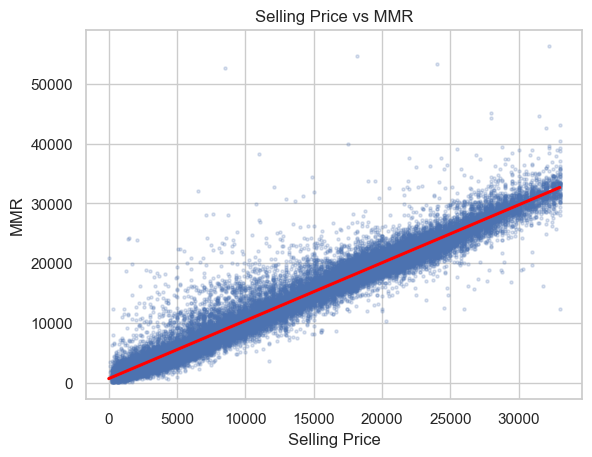

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.scatter(df['sellingprice'], df['mmr'], alpha=0.2, s=5)  
sns.regplot(x='sellingprice', y='mmr', data=df, scatter=False, color='red')  
plt.title('Selling Price vs MMR')  
plt.xlabel('Selling Price')  
plt.ylabel('MMR') 
plt.show()

In [40]:
X = df['mmr']  # Predictor (independent variable)
y = df['sellingprice']  # Target (dependent variable)
r_squared = r2_score(y, X)
print(f"R-squared (R²) between MMR and Selling Price: {r_squared}")


# Create a DataFrame to store R² values
results = pd.DataFrame(columns=['Predictor', 'R_Squared'])
results.loc[0] = ['mmr', r2_score(df['sellingprice'], df['mmr'])]

R-squared (R²) between MMR and Selling Price: 0.9538178923973161


Here we can get a baseline understanding of how accurate MMR is. With an R² of .9538, it explains 95% of 'sellingprice' variance. We will see if we can create a model better than the industry standard! 

#### Using features to predict selling price with Linear Regression
List of numeric features:
1. year
2. condition
3. odometer
4. auto_transmission
5. car_age
6. MSRP

In [41]:
df_predictor = df[['condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP', 'body_size']]
df_target = df['sellingprice']
Xlr = df_predictor
ylr = df_target

# Split into training and testing set
Xlr_train, Xlr_test, Ylr_train, Ylr_test = train_test_split(Xlr, ylr, test_size=0.3, random_state=39)
# Train the Linear Regression model
model = LinearRegression()
model.fit(Xlr_train, Ylr_train)

LinearRegression()

Make predictions and evaluate the model

In [42]:
ylr_pred = model.predict(Xlr_test)
mse = mean_squared_error(Ylr_test, ylr_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2_linreg = r2_score(Ylr_test, ylr_pred)
print(f"R^2 (coefficient of determination): {r2_linreg}")

Mean Squared Error (MSE): 12012438.971288852
R^2 (coefficient of determination): 0.8128656644603673


So, unsuprisingly, our linear regression model did not preform as well as MMR did.

In [43]:
results.loc[1] = ['Linear Regression', r2_linreg]
print(results)

           Predictor  R_Squared
0                mmr   0.953818
1  Linear Regression   0.812866


Ploting predictions from linear regression model vs. actual selling price

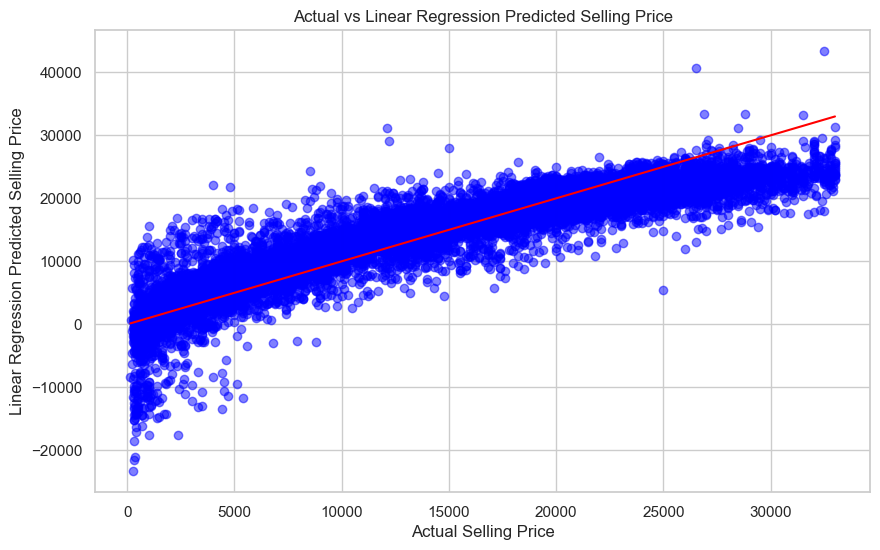

In [44]:
plt.figure(figsize=(10,6))
plt.scatter(Ylr_test, ylr_pred, alpha=0.5, color='blue') 
plt.plot([min(Ylr_test), max(Ylr_test)], [min(Ylr_test), max(Ylr_test)], color='red', linewidth=1.5) # Perfect prediction line
plt.xlabel('Actual Selling Price') 
plt.ylabel('Linear Regression Predicted Selling Price')
plt.title('Actual vs Linear Regression Predicted Selling Price')
plt.show()

#### Standardization and PCA

To visualize using PCA, we must standardize the features using `StandardScaler()` from `sklearn.preprocessing`

In [45]:
numerical_cols = ['odometer', 'condition', 'MSRP', 'car_age']


from sklearn.preprocessing import StandardScaler
# Starting the engine
scaler = StandardScaler()

df_stand = pd.DataFrame(
    scaler.fit_transform(df[numerical_cols]),
    # Keeping the index and 
    index = df.index,
    columns = df[numerical_cols].columns
)

df_stand

,odometer,condition,MSRP,car_age
0,-0.826618,0.582548,0.657560,-1.059310
1,-1.005590,-1.582630,-0.602447,-1.059310
2,-0.821365,-1.685734,-0.070444,-1.059310
3,-0.780987,0.685652,0.902562,-1.059310
4,-0.858563,1.304274,0.902562,-1.059310
...,...,...,...,...
51641,-1.036201,0.685652,-0.719115,-0.789743
51642,-1.011888,1.304274,-0.530113,-0.789743
51643,-0.949208,0.170133,-0.299695,-0.789743
51644,-0.032231,-0.860904,-0.540030,1.097225


In [46]:
from sklearn.decomposition import PCA
df_pca = PCA(n_components = 2).fit(df_stand)

print(f'The variance retained by the first PC is: {round(df_pca.explained_variance_ratio_[0]*100, 2)}%')
print(f'The variance retained by the second PC is: {round(df_pca.explained_variance_ratio_[1]*100, 2)}%')
print(f'for a total variance retained of: {round(sum(df_pca.explained_variance_ratio_)*100, 2)}%')

The variance retained by the first PC is: 58.48%
The variance retained by the second PC is: 24.55%
for a total variance retained of: 83.03%


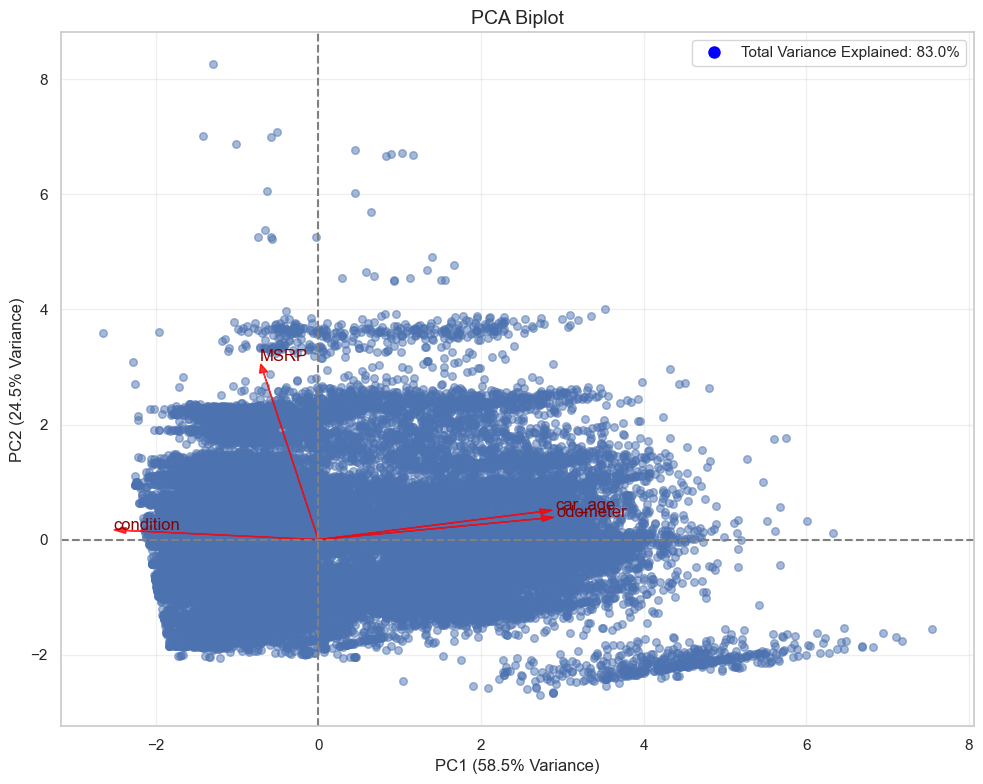

In [47]:
# Source: 19_PCA.ipynb

# Get PCA scores (coordinates of observations in PC space)
scores = df_pca.transform(df_stand)

# Get PCA loadings (contributions of original features to PCs)
loadings = df_pca.components_.T * np.sqrt(df_pca.explained_variance_)

# Create figure
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    x=scores[:, 0],  # PC1 scores
    y=scores[:, 1],  # PC2 scores
    alpha=0.5,
    s=30
)

for i, feature in enumerate(numerical_cols):
    plt.arrow(
        x=0, y=0,
        dx=loadings[i, 0]*3,  # Scaling factor for visibility
        dy=loadings[i, 1]*3,
        color='red',
        alpha=0.8,
        head_width=0.1
    )
    plt.text(
        loadings[i, 0]*3.2,  # Slightly offset from arrow
        loadings[i, 1]*3.2,
        feature,
        color='darkred',
        fontsize=12
    )

plt.title('PCA Biplot', fontsize=14)
plt.xlabel(f'PC1 ({round(df_pca.explained_variance_ratio_[0]*100, 1)}% Variance)')
plt.ylabel(f'PC2 ({round(df_pca.explained_variance_ratio_[1]*100, 1)}% Variance)')
plt.grid(alpha=0.3)
plt.axhline(0, color='grey', ls='--')
plt.axvline(0, color='grey', ls='--')

# Add variance explanation in legend
plt.legend(
    handles=[plt.Line2D([0], [0], marker='o', color='w', label=f'Total Variance Explained: {round(sum(df_pca.explained_variance_ratio_)*100, 1)}%',
             markerfacecolor='blue', markersize=10)],
    loc='best'
)

plt.tight_layout()
plt.show()

Now let's see how the first two PC's can preform when predicting 'sellingprice'

In [48]:
X_pca = df_pca.transform(df_stand)

y_pca = df['sellingprice']
X_pca = X_pca[:, [0, 1]]

X_pca_train, X_pca_test, Y_pca_train, Y_pca_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=39)

model = LinearRegression()

model.fit(X_pca[:, [0, 1]], y_pca)

LinearRegression()

In [49]:
y_pca_pred = model.predict(X_pca_test)
mse = mean_squared_error(Y_pca_test, y_pca_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2_pca2 = r2_score(Y_pca_test, y_pca_pred)
print(f"R^2 (coefficient of determination): {r2_pca2}")

Mean Squared Error (MSE): 12912825.10439531
R^2 (coefficient of determination): 0.7988391073930895


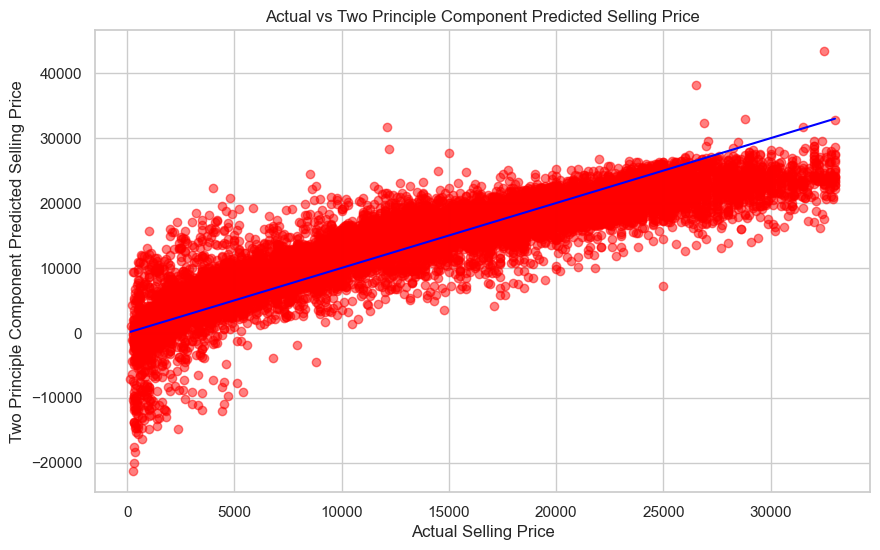

In [50]:
plt.figure(figsize=(10,6))
plt.scatter(Y_pca_test, y_pca_pred, alpha=0.5, color='red') 
plt.plot([min(Y_pca_test), max(Y_pca_test)], [min(Y_pca_test), max(Y_pca_test)], color='blue', linewidth=1.5) # Perfect prediction line
plt.xlabel('Actual Selling Price') 
plt.ylabel('Two Principle Component Predicted Selling Price')
plt.title('Actual vs Two Principle Component Predicted Selling Price')
plt.show()

In [51]:
# Predict and calculate R²
y_pred = model.predict(X_pca[:, [0, 1]])
r_squared = r2_score(y, y_pred)

results.loc[2] = ['PCA (2 pricipal components)', r_squared]
print(results)


                     Predictor  R_Squared
0                          mmr   0.953818
1            Linear Regression   0.812866
2  PCA (2 pricipal components)   0.795830


##### XGBoost

Let's see if XGBoost can do any better, first without tuning paremeters to find a baseline

In [52]:
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(df_predictor, df_target, test_size=0.3, random_state=39) # Create training set

# Materials sourced from lecture slides

In [70]:
xgb_total = (
    XGBRegressor(
        max_depth = 5, 
        n_estimators = 200,
    )
    .fit(X_train, y_train)
)

# Calculating the R-squared using the test data
xgb_R2 = xgb_total.score(X_test, y_test)

print(f'R-squared value before tuning: {xgb_R2}')
results.loc[3] = ['XGBoost (pretuned)', xgb_R2  ]
print(results)


R-squared value before tuning: 0.9538455605506897
                     Predictor  R_Squared
0                          mmr   0.953818
1            Linear Regression   0.812866
2  PCA (2 pricipal components)   0.795830
3           XGBoost (pretuned)   0.953846


To conserve on time & precious computing power for the grid search, let's see if there could be an earlier stopping point

In [55]:
xgbr_esr50 = (
    XGBRegressor(
        n_estimators = 1000,  # Create a thousand trees
        learning_rate = 0.1,  # Learning rate
        random_state = 3870,
        early_stopping_rounds = 50  # Checks to see if there is an improvement 50 trees previously
    )
    .fit(
        X_train, y_train,                # Training set for the model
        eval_set = [(X_train, y_train),  # Calculates the rmse for the training set
                    (X_test, y_test)],   # Calculates the rmse for the testing set
        verbose = False
    )
)

# Saving the validation results
xgb_esr50_df = pd.DataFrame({
    'train error': xgbr_esr50.evals_result()['validation_0']['rmse'],
    'test error':  xgbr_esr50.evals_result()['validation_1']['rmse']
})

print(xgb_esr50_df.nsmallest(n = 1, columns= 'test error').reset_index())

# # Plotting the validation results:
# xgb_esr50_df.plot(kind = 'line')

# # plt.axvline(, color = 'black', linestyle = '--');

   index  train error   test error
0    496  1395.555579  1695.530932


As we know, XGBoost has many hyper parameters. Let's do a grid search to find the best combination

In [56]:
xgb_hp_dict = {
    'learning_rate':    [0.01, 0.05, 0.1, 0.2, 0.3], # Each new prediction's contribution to y_hat
    'n_estimators':     [100, 250, 500, 750, 1000],  # Number of trees to make
    'max_depth':        [1, 3, 5, 7],                # Maximum number of splits: 1, 8, 32, 128 leaf nodes   
    'colsample_bytree': [0.4, 0.6, 0.8, 1],          # Number of features to use per tree (40, 60, 80, & 100%)
    'lambda':           [0, 0.5, 1, 2, 5]            # Regularization parameters to try
}

In [57]:
from sklearn.model_selection import GridSearchCV, KFold

# 5 fold cross-val
cv5 = KFold(n_splits = 5, shuffle = True)

# Defining the model:
xgb_reg = XGBRegressor(random_state = 3870, early_stopping_rounds = 50)

# Defining the grid search
grid_search = GridSearchCV(
    estimator = xgb_reg,
    param_grid = xgb_hp_dict,
    n_jobs = -1,
    cv = cv5    
)

In [61]:
import time

curr_time = time.time()
gs_results = (
    grid_search
    .fit(
        X_train, y_train,
        eval_set = [(X_test, y_test)],
        verbose = False
    )
)
end_time = time.time()

print(f'Wow! That took {end_time - curr_time} seconds')

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Wow! That took 562.9195687770844 seconds


In [66]:
best_hps = grid_search.best_params_
print(f'After many iterations... the best paremeters are')
best_hps

After many iterations... the best paremeters are


{'colsample_bytree': 0.8,
 'lambda': 5,
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 1000}

Now that the hard work is done, let's use these hyperparemeters

In [74]:
best_xgb = (
    XGBRegressor(
        **best_hps,
    )
    .fit(
        X_train, y_train,
        eval_set = [(X_test, y_test)],
        verbose = False
    )
)

xgb_tuned_r2 = best_xgb.score(X_test, y_test)
results.loc[4] = ['XGB (tuned)', xgb_tuned_r2]
print(results.sort_values(by = 'R_Squared', ascending = False))

                     Predictor  R_Squared
4                  XGB (tuned)   0.956010
3           XGBoost (pretuned)   0.953846
0                          mmr   0.953818
1            Linear Regression   0.812866
2  PCA (2 pricipal components)   0.795830


Wow! The r-squared is higher than MMR.

#### Random Forest

First let's import the proper packages

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Next we need to select the same predictor features as before and train-test split the data

In [ ]:
df_predictor = df[['condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP', 'body_size']]
df_target = df['sellingprice']

X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(df_predictor, df_target, test_size=0.3, random_state=39)

Now we can start the Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=31)
rf_model.fit(X_rf_train, Y_rf_train)

From here, we can make predicitons and look at the model's accuracy.

In [ ]:
Y_rf_pred = rf_model.predict(X_rf_test)

mse_rf = mean_squared_error(Y_rf_test, Y_rf_pred)
r2_rf = r2_score(Y_rf_test, Y_rf_pred)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

The Random Forest Model gives us a very strong R^2 value. Let's visualize the actual vs predicted values next. 

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(Y_rf_test, Y_rf_pred, alpha=0.5, color='blue')
plt.plot([min(Y_rf_test), max(Y_rf_test)], [min(Y_rf_test), max(Y_rf_test)], color='red', linewidth=1.0) 
plt.ylabel('Random Forest Predicted Selling Price')
plt.title('Actual vs Random Forest Predicted Selling Price')
plt.show()

#### Feature Importance

We can also investigate what features were the most important in the splits of the trees. 

In [ ]:
feat_imp = pd.DataFrame({
    'feature': df_predictor.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

feat_imp

In [ ]:
feat_imp.set_index('feature').plot(kind = 'bar');

This means that the age of the car was the most important feature to the splitting of the trees

##### Model Results

In [ ]:
results.loc[3] = ['Random Forest Regression', r2_rf]
print(results)

What these R-squared values mean is that MMR is the best prediciton for sales price. This makes sense due to MMR being a wholesale market valuation of the car. However, the best model we have built so far is the Random Forest with the highest R-squared value.